# 1. Data



## Loading Data

In [ ]:
#non standard colab libraries:
#!pip install GetOldTweets3
#!pip install BeautifulSoup4
#!pip install requests
from google.colab import drive
from google.colab import files

#Importing packages
import numpy as np #for multidimensional matrices
import pandas as pd #for data analysis
import datetime #to work with dates and times
from bs4 import BeautifulSoup

#Other Relevant Libraries
import string
import collections
import io
#!pip install nltk
import nltk
nltk.download('all')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#mount drive
drive.mount('/content/drive/')
root_path = '/content/My Drive/Trump Tweets/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#reading csv file
gotscrapeurl='https://raw.githubusercontent.com/WouterJTB/TWUMP/master/TrumpTweetsGOTscrape.csv'
df=pd.DataFrame(data=pd.read_csv(gotscrapeurl, parse_dates=['date']))
df #print

,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo
0,1237861968721010689,2020-03-11 22:04:26+00:00,The Media should view this as a time of unity ...,NaN,NaN,NaN,47393,237273,https://twitter.com/realDonaldTrump/status/123...,NaN
1,1237841878889840642,2020-03-11 20:44:36+00:00,I will be addressing the Nation this evening a...,NaN,NaN,NaN,27031,127048,https://twitter.com/realDonaldTrump/status/123...,NaN
2,1237820230296010752,2020-03-11 19:18:35+00:00,I am fully prepared to use the full power of t...,NaN,NaN,NaN,27966,151657,https://twitter.com/realDonaldTrump/status/123...,NaN
3,1237820044198977536,2020-03-11 19:17:50+00:00,"....We have the greatest healthcare system, ex...",NaN,NaN,NaN,9556,40112,https://twitter.com/realDonaldTrump/status/123...,NaN
4,1237820042735226887,2020-03-11 19:17:50+00:00,I want to thank all of our Great Government of...,NaN,NaN,NaN,13479,53168,https://twitter.com/realDonaldTrump/status/123...,NaN
...,...,...,...,...,...,...,...,...,...,...
41909,1773561338,2009-05-12 14:07:28+00:00,"""My persona will never be that of a wallflower...",NaN,NaN,NaN,1384,1962,https://twitter.com/realDonaldTrump/status/177...,NaN
41910,1741160716,2009-05-08 20:40:15+00:00,New Blog Post: Celebrity Apprentice Finale and...,NaN,NaN,NaN,10,26,https://twitter.com/realDonaldTrump/status/174...,NaN
41911,1737479987,2009-05-08 13:38:08+00:00,Donald Trump reads Top Ten Financial Tips on L...,NaN,NaN,NaN,12,19,https://twitter.com/realDonaldTrump/status/173...,NaN
41912,1701461182,2009-05-05 01:00:10+00:00,Donald Trump will be appearing on The View tom...,NaN,NaN,NaN,33,271,https://twitter.com/realDonaldTrump/status/170...,NaN


## Twitter scrapeloop

Trump tweets

In [ ]:
#Installing GetOldTweets
!pip install GetOldTweets3
import GetOldTweets3 as got

In [ ]:
#for setting a loop timer
# import datetime
import time
#the loop
while True:
    #check what data is in the dataframe
    try:
      dx = df['date'].min().date() + datetime.timedelta(days=1)      
      lr_date = dx.strftime("%Y-%m-%d")
      #GOT3 finds tweets in date descending order (most recent first)
      #date is +1 day because GetOldTweets query parameter ".setUntil" scrapes until date excluding(!) the input date

    #if no data is available, scrape backwards from today
    except NameError:
      lr_date = datetime.date.today().strftime("%Y-%m-%d")
    
    #set other query values (count=1500 per scrape to avoid block by Twitter API)
    username='realDonaldTrump'
    count=1500

    # Creation of query object
    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                                        .setUntil(lr_date)\
                                        .setMaxTweets(count)
    # Creation of list that contains all tweets
    gotTweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Creating list of chosen tweet data

    got_trumpTweets = [[tweet.id, tweet.date, tweet.text, tweet.to, tweet.mentions, tweet.hashtags, tweet.retweets, tweet.favorites, tweet.permalink, tweet.geo] for tweet in gotTweets]
    dfGTT=pd.DataFrame(data=got_trumpTweets, columns=['id', 'date', 'content', 'response_to', 'mentions', 'hashtags', 'retweets', 'favorites', 'link', 'geo'])
    
    #add scraped data to dataframe: df, or create new df if df is not found
    try:
      df=df.append(dfGTT, ignore_index=True)
    except BaseException:
      print('df not found')
      df=dfGTT
    #remove duplicates due to partial overlap in set dates for scraping
    df=df.drop_duplicates()
    
    #To save/update to file include line: "df.to_csv('/content/drive/My Drive/Trump Tweets/TrumpTweetsGOTscrape.csv', index=False)"


    #end or loop logic, "checkdate" is least recent date in df, "mindate" is date of Trumps first tweet +1 day
    checkdate = df['date'].min().date()
    mindate = datetime.date(2009, 5,5)
    if checkdate < mindate:
      print("scraping completed")
      break
    else:
      print("tweets added, scraping again")
      time.sleep(120)

scraping completed


## Data cleaning

In [ ]:
# add content_nohtml, converts html commands (like "&amp" or "<div>)" to text
import warnings
#a bunch of Trump's tweets have URL's in them, which will trigger warnings for BS4, lets ignore these as the URL's will be removed at a later point.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4', message='.*looks like a URL.*')
df['content_nohtml']=[BeautifulSoup(text, 'lxml').get_text() for text in df['content'].astype(str) ]

##Retweets and Favorites

In [ ]:
df = df.sort_values(by='retweets', ascending=False)
df.head()

,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml
9843,881503147168071680,2017-07-02 13:21:42+00:00,#FraudNewsCNN #FNN,NaN,NaN,#FraudNewsCNN #FNN,307364,524820,https://twitter.com/realDonaldTrump/status/881...,NaN,#FraudNewsCNN #FNN
11006,795954831718498305,2016-11-08 11:43:14+00:00,TODAY WE MAKE AMERICA GREAT AGAIN!,NaN,NaN,NaN,294133,516293,https://twitter.com/realDonaldTrump/status/795...,NaN,TODAY WE MAKE AMERICA GREAT AGAIN!
26380,474134260149157888,2014-06-04 10:23:11+00:00,Are you allowed to impeach a president for gro...,NaN,NaN,NaN,244841,237198,https://twitter.com/realDonaldTrump/status/474...,NaN,Are you allowed to impeach a president for gro...
3273,1157345692517634049,2019-08-02 17:41:30+00:00,A$AP Rocky released from prison and on his way...,NaN,NaN,NaN,237381,850869,https://twitter.com/realDonaldTrump/status/115...,NaN,A$AP Rocky released from prison and on his way...
8839,929511061954297857,2017-11-12 00:48:01+00:00,Why would Kim Jong-un insult me by calling me ...,NaN,NaN,NaN,227559,555921,https://twitter.com/realDonaldTrump/status/929...,NaN,Why would Kim Jong-un insult me by calling me ...


In [ ]:
print(df['content'].iloc[0])

#FraudNewsCNN #FNN


Trump's most retweeted tweet is:

*\# FraudNewsCNN \# FNNpic.twitter.com/WYUnHjjUjg*

stemming from 2017-07-02 15:21:42, gaining **309892** retweets and **528265** favorites.

In [ ]:
df = df.reset_index(drop=True)
round(df['retweets'].mean(),2)

5664.04

Trump's tweets are retweeted by a mean of **5455.59**.

Here are his top ten retweets, including the amount of times they were retweeted:

In [ ]:
for i in range(10):
    print(i+1, '-', df['content'].iloc[i], '-', df['retweets'].iloc[i])
print('\n')

1 - #FraudNewsCNN #FNN - 307364
2 - TODAY WE MAKE AMERICA GREAT AGAIN! - 294133
3 - Are you allowed to impeach a president for gross incompetence? - 244841
4 - A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP! - 237381
5 - Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen! - 227559
6 - Be prepared, there is a small chance that our horrendous leadership could unknowingly lead us into World War III. - 220144
7 - nan - 192955
8 - Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helping A$AP Rocky. So many people would like to see this quickly resolved! - 192368
9 - Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come tog

A couple of tweets are actually pictures without text (except for text in the picture) these show up as 'nan' in this case.

In [ ]:
df = df.sort_values(by='favorites', ascending=False)
df.head()

,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml
3,1157345692517634049,2019-08-02 17:41:30+00:00,A$AP Rocky released from prison and on his way...,NaN,NaN,NaN,237381,850869,https://twitter.com/realDonaldTrump/status/115...,NaN,A$AP Rocky released from prison and on his way...
9,1212924762827046918,2020-01-03 02:32:53+00:00,NaN,NaN,NaN,NaN,168381,801336,https://twitter.com/realDonaldTrump/status/121...,NaN,nan
11,1214739853025394693,2020-01-08 02:45:24+00:00,All is well! Missiles launched from Iran at tw...,NaN,NaN,NaN,154841,755712,https://twitter.com/realDonaldTrump/status/121...,NaN,All is well! Missiles launched from Iran at tw...
33,1221582230008619016,2020-01-26 23:54:34+00:00,"Kobe Bryant, despite being one of the truly gr...",NaN,NaN,NaN,92953,733417,https://twitter.com/realDonaldTrump/status/122...,NaN,"Kobe Bryant, despite being one of the truly gr..."
22,1209812664601522178,2019-12-25 12:26:31+00:00,MERRY CHRISTMAS!,NaN,NaN,NaN,111279,729237,https://twitter.com/realDonaldTrump/status/120...,NaN,MERRY CHRISTMAS!


In [ ]:
print(df['content'].iloc[0])

A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!


Trump's most favorited tweet is:

*A\$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A\$AP!*

stemming from 2019-08-02 19:41:30, gaining **240363** retweets and **812508** favorites.

In [ ]:
df = df.reset_index(drop=True)
round(df['favorites'].mean(),2)

23408.11

Trump's tweets are favorited by a mean of **22356.9**.

Here are his top ten favorited tweets, including the amount of times they were favorited:

In [ ]:
for i in range(10):
    print(i+1, '-', df['content'].iloc[i], '-', df['favorites'].iloc[i])
print('\n')

1 - A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP! - 850869
2 - nan - 801336
3 - All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties & damages taking place now. So far, so good! We have the most powerful and well equipped military anywhere in the world, by far! I will be making a statement tomorrow morning. - 755712
4 - Kobe Bryant, despite being one of the truly great basketball players of all time, was just getting started in life. He loved his family so much, and had such strong passion for the future. The loss of his beautiful daughter, Gianna, makes this moment even more devastating.... - 733417
5 - MERRY CHRISTMAS! - 729237
6 - Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helping A$AP Rocky. So many people would like to see this quickly 

Again, note that some of his most retweeted tweets are in fact pictures.

### Time Series

In [ ]:
df = df.sort_values(by='date', ascending=True)
df['ts'] = pd.to_datetime(df['date'])
df = df.set_index('ts')
df.head()

,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml
ts,,,,,,,,,,,
2009-05-04 18:54:25+00:00,1698308935,2009-05-04 18:54:25+00:00,Be sure to tune in and watch Donald Trump on L...,None,,,507,900,https://twitter.com/realDonaldTrump/status/169...,,Be sure to tune in and watch Donald Trump on L...
2009-05-04 18:54:25+00:00,1698308935,2009-05-04 18:54:25+00:00,Be sure to tune in and watch Donald Trump on L...,NaN,NaN,NaN,501,867,https://twitter.com/realDonaldTrump/status/169...,NaN,Be sure to tune in and watch Donald Trump on L...
2009-05-05 01:00:10+00:00,1701461182,2009-05-05 01:00:10+00:00,Donald Trump will be appearing on The View tom...,NaN,NaN,NaN,33,271,https://twitter.com/realDonaldTrump/status/170...,NaN,Donald Trump will be appearing on The View tom...
2009-05-08 13:38:08+00:00,1737479987,2009-05-08 13:38:08+00:00,Donald Trump reads Top Ten Financial Tips on L...,NaN,NaN,NaN,12,19,https://twitter.com/realDonaldTrump/status/173...,NaN,Donald Trump reads Top Ten Financial Tips on L...
2009-05-08 20:40:15+00:00,1741160716,2009-05-08 20:40:15+00:00,New Blog Post: Celebrity Apprentice Finale and...,NaN,NaN,NaN,10,26,https://twitter.com/realDonaldTrump/status/174...,NaN,New Blog Post: Celebrity Apprentice Finale and...


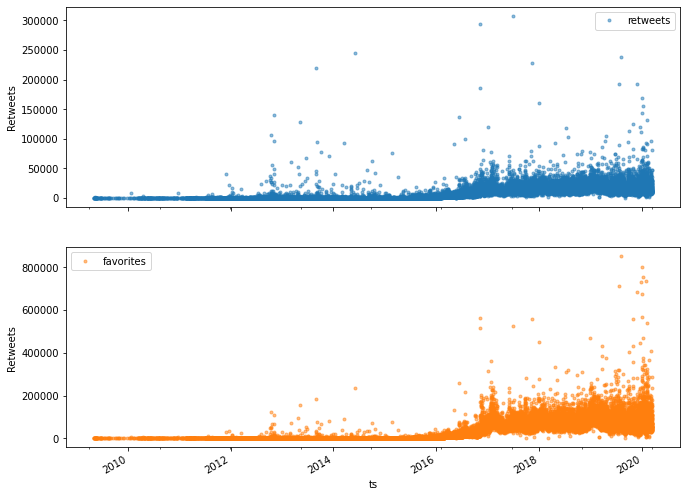

In [ ]:
retweets_plot = ['retweets', 'favorites']
axes = df[retweets_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Retweets')

There is a clear increasing trend in both retweets and favourites.

## When does Trump Tweet?

In [ ]:
df.reset_index(level=0, inplace=True)
df['hour_of_day'] = [t.hour for t in df.ts]
df['day_of_the_week'] = [t.dayofweek for t in df.ts]

hour_of_day_count = {}
day_of_the_week_count = {}
weekday_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [ ]:
for i in df.index:
    hour_of_day = df.iloc[i]['hour_of_day']
    day_of_the_week = df.iloc[i]['day_of_the_week']
    # Count tweets made at certain hours in the day
    if hour_of_day in hour_of_day_count:
        hour_of_day_count[hour_of_day] += 1
    else:
        hour_of_day_count[hour_of_day] = 1
    # Count tweets made at certain days of the week
    if day_of_the_week in day_of_the_week_count:
        day_of_the_week_count[day_of_the_week] += 1
    else:
        day_of_the_week_count[day_of_the_week] = 1

In [ ]:
for key in sorted(hour_of_day_count):
    print(key, '-', key+1, ':', hour_of_day_count[key], 'tweets')

0 - 1 : 1716 tweets
1 - 2 : 1917 tweets
2 - 3 : 2043 tweets
3 - 4 : 1703 tweets
4 - 5 : 940 tweets
5 - 6 : 615 tweets
6 - 7 : 401 tweets
7 - 8 : 325 tweets
8 - 9 : 424 tweets
9 - 10 : 533 tweets
10 - 11 : 1146 tweets
11 - 12 : 1946 tweets
12 - 13 : 2434 tweets
13 - 14 : 2510 tweets
14 - 15 : 2356 tweets
15 - 16 : 2295 tweets
16 - 17 : 2197 tweets
17 - 18 : 1939 tweets
18 - 19 : 2535 tweets
19 - 20 : 3016 tweets
20 - 21 : 3237 tweets
21 - 22 : 2327 tweets
22 - 23 : 1708 tweets
23 - 24 : 1643 tweets


Trump seems to be most active in the evening.

In [ ]:
for key in day_of_the_week_count:
    print(weekday_dict[key], ':', day_of_the_week_count[key], ' tweets')

Mon : 6775  tweets
Tue : 7080  tweets
Fri : 6208  tweets
Wed : 7235  tweets
Thu : 6691  tweets
Sat : 4042  tweets
Sun : 3875  tweets


Trump seems to take time of from Twitter in the weekend.

In [ ]:
#the raw dataset includes a 'date' field, which is technically a 'datetime' field. This field is renamed as 'datetime' and then split in date, time, day, month, year
df = df.sort_values(by='date', ascending=False)
df['datetime']=df['date']

df['date'] = df['datetime'].map(lambda x: x.date)
df["day"] = df['datetime'].map(lambda x: x.day)
df["month"] = df['datetime'].map(lambda x: x.month)
df["year"] = df['datetime'].map(lambda x: x.year)
df['time'] = df['datetime'].map(lambda x: x.time)

In [ ]:
df['dayofweek'] = df['datetime'].apply(lambda time: time.dayofweek)
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x > 4 else 0)
df['partofday'] = df['datetime'].apply(lambda time: 'morning' if 6<= time.hour <= 11 else ('afternoon' if 11< time.hour <= 17 else 'night'))

Exploratory data analysis:

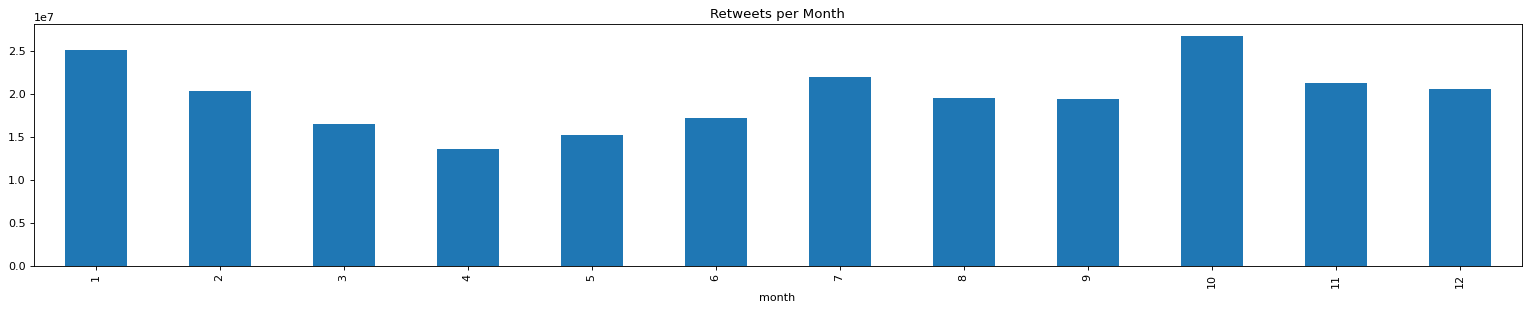

In [ ]:
#amount of retweets per month
plt.figure(figsize=(24, 4), dpi=80)
retweets = df.groupby(df["month"]).sum()['retweets']
retweets.plot(kind='bar', title='Retweets per Month')


October is Trump's most active tweeting month.

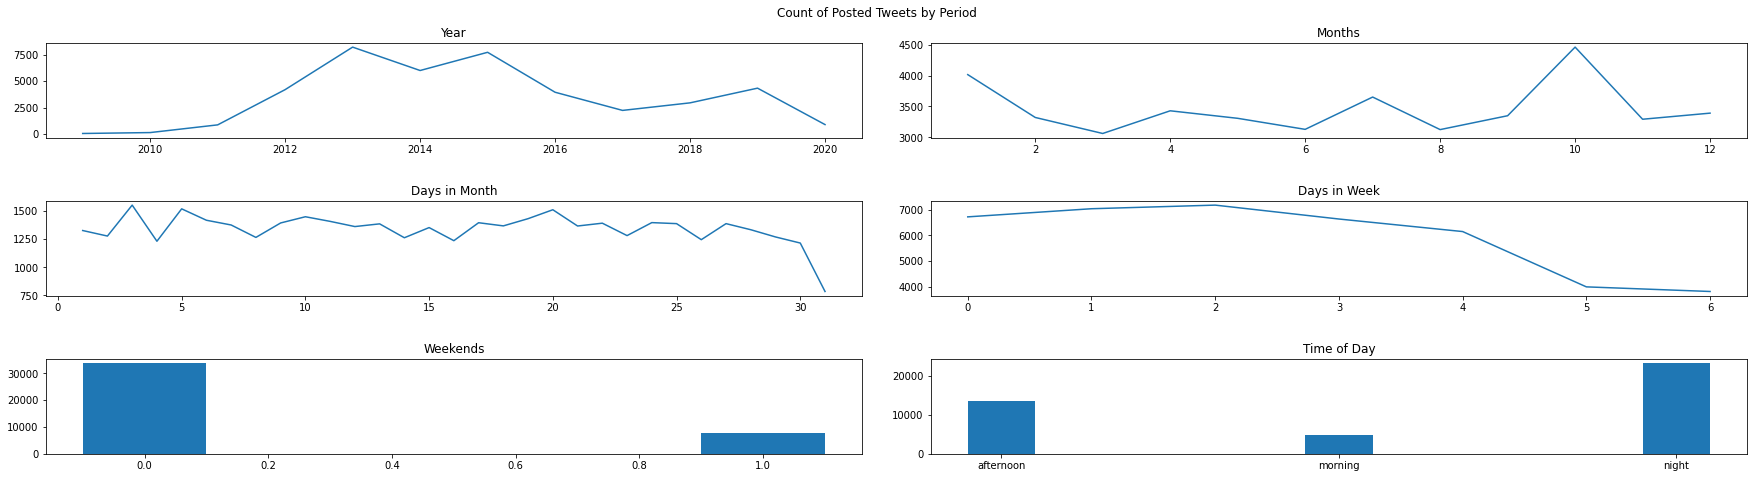

In [ ]:
#Overview of tweet frequency per period
year = df.groupby(df["datetime"].dt.year).count()['content']
month = df.groupby(df["datetime"].dt.month).count()['content']
days = df.groupby(df["datetime"].dt.day).count()['content']
weekdays = df.groupby(df["dayofweek"]).count()['content']
weekends = df.groupby(df["weekend"]).count()['content']
timeofday = df.groupby(df["partofday"]).count()['content']

weekends = df.groupby(df["weekend"]).count()['content'].to_frame()
timeofday = df.groupby(df["partofday"]).count()['content'].to_frame()
weekendsheight = list(weekends['content'])
timeofdayheight = list(timeofday['content'])
weekendsnames = list(weekends.index.values)
timeofdaynames = list(timeofday.index.values)

fig, ((ax1, ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(25,7))
fig.suptitle('Count of Posted Tweets by Period')
ax1.set_title('Year')
ax1.plot(year)
ax2.set_title('Months')
ax2.plot(month)
ax3.set_title('Days in Month')
ax3.plot(days)
ax4.set_title('Days in Week')
ax4.plot(weekdays)
ax5.set_title('Weekends')
ax5.bar(weekendsnames,weekendsheight, width=0.2)
ax6.set_title('Time of Day')
ax6.bar(timeofdaynames,timeofdayheight, width=0.2)

fig.tight_layout(pad=3.0)

Again, October is the most active tweet month. This might be due to Election Day being at the start of November.

In [ ]:
# import string
def standardize_text(df, text_field):
    # normalize by turning all letters into lowercase
    df[text_field] = df[text_field].str.lower()
    return df

# clear retweet identifiers in content, as well as URL's, then standardize the text
df['cleancontent'] = df['content_nohtml'].astype(str).apply(lambda x : ' '.join([w for w in x.split() if not w.startswith(('rt @', 'http', 'pic.'))]))
df["cleancontent"] = [str(x).translate(str.maketrans('', '', string.punctuation)) for x in df['cleancontent']]
df['cleancontent'] = df['cleancontent'].str.lower()

#a new dataframe is created to do some further edits
cleantext = df[['id','datetime','retweets','favorites','time','date','year','month','day','dayofweek','weekend','partofday','hour_of_day','cleancontent' ]].sort_values(by='date', ascending=False)

# REMOVE PUNCTUATION
cleantext["cleancontent"] = [str(x).translate(str.maketrans('', '', string.punctuation)) for x in cleantext['cleancontent']]
standardize_text(cleantext, 'cleancontent')
cleantext.head()

,id,datetime,retweets,favorites,time,date,year,month,day,dayofweek,weekend,partofday,hour_of_day,cleancontent
41905,1237861968721010689,2020-03-11 22:04:26+00:00,47393,237273,22:04:26,2020-03-11,2020,3,11,2,0,night,22,the media should view this as a time of unity ...
41895,1237612361353007104,2020-03-11 05:32:35+00:00,9683,48151,05:32:35,2020-03-11,2020,3,11,2,0,night,5,thank you idaho kag2020
41887,1237541916398325761,2020-03-11 00:52:39+00:00,10208,46901,00:52:39,2020-03-11,2020,3,11,2,0,night,0,thank you mississippi kag2020
41888,1237542616813539328,2020-03-11 00:55:26+00:00,11048,51296,00:55:26,2020-03-11,2020,3,11,2,0,night,0,thank you missouri kag2020
41889,1237545548430770178,2020-03-11 01:07:05+00:00,11289,52897,01:07:05,2020-03-11,2020,3,11,2,0,night,1,thank you michigan kag2020


In [ ]:
df.head()

,ts,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml,hour_of_day,day_of_the_week,datetime,day,month,year,time,dayofweek,weekend,partofday,cleancontent
41905,2020-03-11 22:04:26+00:00,1237861968721010689,2020-03-11,The Media should view this as a time of unity ...,NaN,NaN,NaN,47393,237273,https://twitter.com/realDonaldTrump/status/123...,NaN,The Media should view this as a time of unity ...,22,2,2020-03-11 22:04:26+00:00,11,3,2020,22:04:26,2,0,night,the media should view this as a time of unity ...
41904,2020-03-11 20:44:36+00:00,1237841878889840642,2020-03-11,I will be addressing the Nation this evening a...,NaN,NaN,NaN,27031,127048,https://twitter.com/realDonaldTrump/status/123...,NaN,I will be addressing the Nation this evening a...,20,2,2020-03-11 20:44:36+00:00,11,3,2020,20:44:36,2,0,night,i will be addressing the nation this evening a...
41903,2020-03-11 19:18:35+00:00,1237820230296010752,2020-03-11,I am fully prepared to use the full power of t...,NaN,NaN,NaN,27966,151657,https://twitter.com/realDonaldTrump/status/123...,NaN,I am fully prepared to use the full power of t...,19,2,2020-03-11 19:18:35+00:00,11,3,2020,19:18:35,2,0,night,i am fully prepared to use the full power of t...
41902,2020-03-11 19:17:50+00:00,1237820042735226887,2020-03-11,I want to thank all of our Great Government of...,NaN,NaN,NaN,13479,53168,https://twitter.com/realDonaldTrump/status/123...,NaN,I want to thank all of our Great Government of...,19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,i want to thank all of our great government of...
41901,2020-03-11 19:17:50+00:00,1237820044198977536,2020-03-11,"....We have the greatest healthcare system, ex...",NaN,NaN,NaN,9556,40112,https://twitter.com/realDonaldTrump/status/123...,NaN,"....We have the greatest healthcare system, ex...",19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,we have the greatest healthcare system experts...


In [ ]:
## [PREPROCESS] Tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

cleantext["tokens"] = cleantext["cleancontent"].apply(tokenizer.tokenize)
cleantext.head()

,id,datetime,retweets,favorites,time,date,year,month,day,dayofweek,weekend,partofday,hour_of_day,cleancontent,tokens
41905,1237861968721010689,2020-03-11 22:04:26+00:00,47393,237273,22:04:26,2020-03-11,2020,3,11,2,0,night,22,the media should view this as a time of unity ...,"[the, media, should, view, this, as, a, time, ..."
41895,1237612361353007104,2020-03-11 05:32:35+00:00,9683,48151,05:32:35,2020-03-11,2020,3,11,2,0,night,5,thank you idaho kag2020,"[thank, you, idaho, kag2020]"
41887,1237541916398325761,2020-03-11 00:52:39+00:00,10208,46901,00:52:39,2020-03-11,2020,3,11,2,0,night,0,thank you mississippi kag2020,"[thank, you, mississippi, kag2020]"
41888,1237542616813539328,2020-03-11 00:55:26+00:00,11048,51296,00:55:26,2020-03-11,2020,3,11,2,0,night,0,thank you missouri kag2020,"[thank, you, missouri, kag2020]"
41889,1237545548430770178,2020-03-11 01:07:05+00:00,11289,52897,01:07:05,2020-03-11,2020,3,11,2,0,night,1,thank you michigan kag2020,"[thank, you, michigan, kag2020]"


In [ ]:
#Lemmatizing
wn=nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
  text = [wn.lemmatize(word) for word in tokenized_text]
  return text
  
#Stemming
ps = nltk.PorterStemmer()
def stemming(tokenized_text):
  text = [ps.stem(word) for word in tokenized_text]
  return text

newtable = cleantext.copy()
#table['stemmed'] = table['tokens'].apply(lambda x: stemming(x))
newtable['lemmatized'] = newtable['tokens'].apply(lambda x: lemmatizing(x))
newtable.head()

,id,datetime,retweets,favorites,time,date,year,month,day,dayofweek,weekend,partofday,hour_of_day,cleancontent,tokens,lemmatized
41905,1237861968721010689,2020-03-11 22:04:26+00:00,47393,237273,22:04:26,2020-03-11,2020,3,11,2,0,night,22,the media should view this as a time of unity ...,"[the, media, should, view, this, as, a, time, ...","[the, medium, should, view, this, a, a, time, ..."
41895,1237612361353007104,2020-03-11 05:32:35+00:00,9683,48151,05:32:35,2020-03-11,2020,3,11,2,0,night,5,thank you idaho kag2020,"[thank, you, idaho, kag2020]","[thank, you, idaho, kag2020]"
41887,1237541916398325761,2020-03-11 00:52:39+00:00,10208,46901,00:52:39,2020-03-11,2020,3,11,2,0,night,0,thank you mississippi kag2020,"[thank, you, mississippi, kag2020]","[thank, you, mississippi, kag2020]"
41888,1237542616813539328,2020-03-11 00:55:26+00:00,11048,51296,00:55:26,2020-03-11,2020,3,11,2,0,night,0,thank you missouri kag2020,"[thank, you, missouri, kag2020]","[thank, you, missouri, kag2020]"
41889,1237545548430770178,2020-03-11 01:07:05+00:00,11289,52897,01:07:05,2020-03-11,2020,3,11,2,0,night,1,thank you michigan kag2020,"[thank, you, michigan, kag2020]","[thank, you, michigan, kag2020]"


In [ ]:
all_words = [word for tokens in newtable["lemmatized"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in newtable["lemmatized"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print (VOCAB[0:5])

# What are the most commonly occuring words
from collections import Counter
count_all_words = Counter(all_words)

# get the top 50 most common occuring words
count_all_words.most_common(10)

794795 words total, with a vocabulary size of 39059
['0', '00', '000', '000he', '000hermansjr000']


[('the', 32998),
 ('to', 18921),
 ('a', 16570),
 ('and', 14751),
 ('of', 12698),
 ('is', 12350),
 ('in', 11381),
 ('you', 9730),
 ('for', 9559),
 ('i', 9246)]

In [ ]:
unwantedwords='realDonaldTrump','realdonaldtrump', 'Donald', '.', '&', '-', 'A', '"', 'the', ''
#unwantedwords='!@#"', 'realDonaldTrump','realdonaldtrump', 'Donald', '.', '&', '-', 'A', '"', 'the', ''
clean_words=all_words
for char in unwantedwords:
    clean_words = [w.replace(char,"") for w in clean_words]

count_all_words = Counter(clean_words)

# get the top 100 most common occuring words
count_all_words.most_common(10)

[('', 41568),
 ('to', 18921),
 ('a', 16570),
 ('and', 14751),
 ('of', 12698),
 ('is', 12351),
 ('in', 11381),
 ('you', 9730),
 ('for', 9559),
 ('i', 9247)]

In [ ]:
from nltk.corpus import stopwords
sr= stopwords.words('english')
clean_tokens = clean_words

clean_tokens = [token for token in clean_tokens if token not in sr]
clean_tokens = [token for token in clean_tokens if token] # clean '' empty space
#for token in clean_words:
    #if token in sr:
        #clean_tokens.remove(token)
count_new_tokens = Counter(clean_tokens)
count_new_tokens.most_common(5)

[('great', 6331),
 ('trump', 5373),
 ('wa', 3297),
 ('ha', 2965),
 ('president', 2931)]

In [ ]:
wordlist = count_new_tokens.most_common()
wordlist = pd.DataFrame(data=wordlist, columns=['word','freq'])

#Categorizing and Tagging Words
wordlist['Tag'] = nltk.pos_tag(wordlist['word'])
wordlist['Tag'] = [str(x) for x in wordlist['Tag'].str[1]]

bagofwords = wordlist['word'].values.tolist()
#bagofwords[:10]

wordlist.head(10)

,word,freq,Tag
0,great,6331,JJ
1,trump,5373,NN
2,wa,3297,NN
3,ha,2965,NN
4,president,2931,NN
5,thank,2876,NN
6,people,2557,NNS
7,u,2509,JJ
8,country,2189,NN
9,thanks,2160,NNS


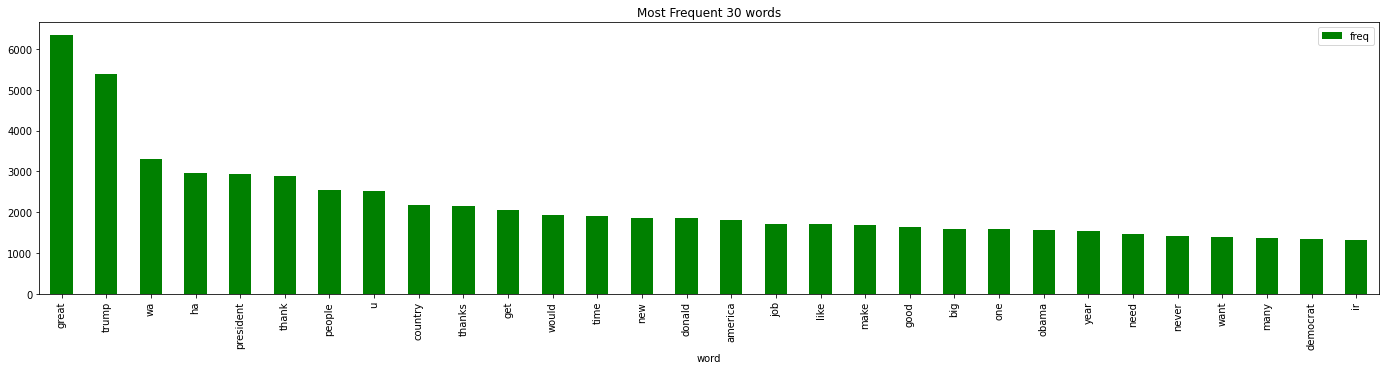

In [ ]:
smallsample = wordlist.iloc[:30]
smallsample[:5]
smallsample.plot(kind='bar',x='word',y='freq', color='g',title='Most Frequent 30 words', figsize=(24,5))

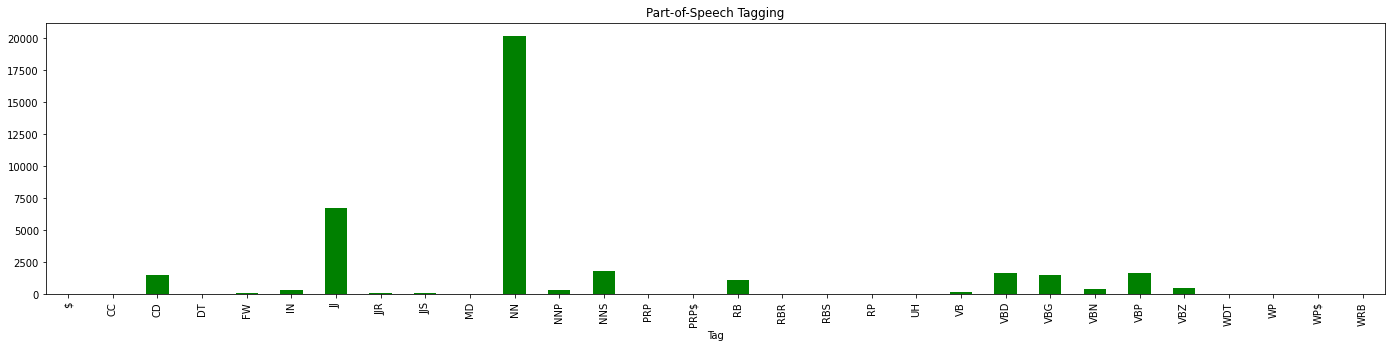

In [ ]:
category = wordlist.groupby(wordlist['Tag']).count()['word']
category.plot(kind='bar', title='Part-of-Speech Tagging',color='g',figsize=(24,5))

![](https://drive.google.com/uc?id=1Z2Sr70L-Dj_JNGHlnV-WLGlfPigt-8pW)

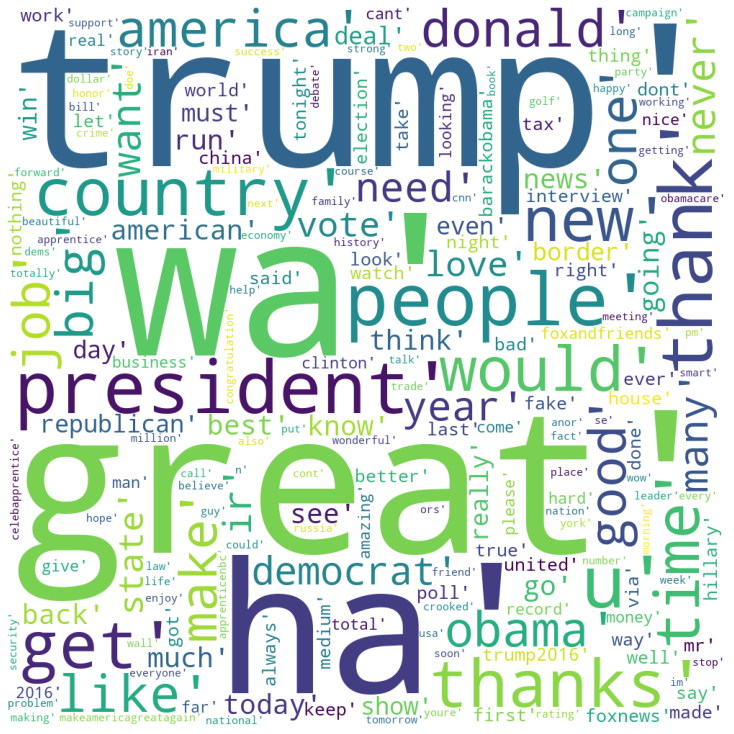

In [ ]:
stopwords = set(STOPWORDS)
wordcloud=WordCloud(width=1000,height=1000, background_color='white', stopwords=stopwords,min_font_size=10).generate(str(bagofwords))
plt.figure(figsize=(10,10),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Note that wa and ha are stems of was and has respectively.

# 2. Models

*This notebook section could be run seperately, although some imports would have to be added, as described in the notes*. For readability the data composition of the datasets is done in each subheading for each separate algorithm.

## Unsupervised: Topic Modelling

###Topic modelling
To discover topics based on their contents, topic modelling was used; specifically NMF and LDA.

In [ ]:
rawdocument = list(newtable['cleancontent'])

# normalize by turning all letters into lowercase , remove punctuation & unwanted words
def clean_text(df):
    df = [x.lower() for x in df]
    df = [str(x).translate(str.maketrans('', '', string.punctuation)) for x in df]
    for word in unwantedwords:
      df = [x.replace(word,"") for x in df]  
    return df

# call the text cleaning function
unwantedwords='realdonaldtrump','…','”','“','’'
document = clean_text(rawdocument)
print(len(document))
document[:10]

41906


['the media should view this as a time of unity and strength we have a common enemy actually an enemy of the world the coronavirus we must beat it as quickly and safely as possible there is nothing more important to me than the life  safety of the united states',
 'thank you idaho kag2020',
 'thank you mississippi kag2020',
 'thank you missouri kag2020',
 'thank you michigan kag2020',
 'tommy tuberville ttuberville is running for the us senate from the great state of alabama tommy was a terrific head football coach at auburn university he is a real leader who will never let magakag or our country down tommy will protect your second amendment',
 'which is under siege is strong on crime and the border and truly loves our military and our vets he will be a great senator for the people of alabama coach tommy tuberville a winner has my complete and total endorsement i love alabama',
 'thank you north dakota kag2020',
 'thank you washington kag2020',
 'pocahontas working in conjunction with 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = len(document)

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(document)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(document)
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [ ]:
# Create Function for Displaying Results
pd.set_option('display.max_colwidth', None)

def list_topics(feature_names, no_top_words,*models):
    global topicmodel
    temp = []
    for model in models:
      for topic_idx, topic in enumerate(model.components_):
          #A = "Topic %d:" % (topic_idx)
          B = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
          C= str(model).upper().split('(')[0]
          temp.append(B)
    topicmodel=pd.DataFrame(data=temp, columns=[C])
    return topicmodel

#Call the function
no_top_words = 5
print(list_topics(tfidf_feature_names, no_top_words,nmf))
print(list_topics(tf_feature_names, no_top_words,lda))

                                             NMF
0                     thanks luck nice good love
1                   thank nice maga support love
2                    nan हम favorite fargo farce
3                      great job honor guy today
4                      people just good like big
5                   president run 2016 vote need
6                     trump donald mr 2016 tower
7  trump2016 makeamericagreatagain new poll join
8                     true thats leader need man
9                   america make needs lets safe
                          LATENTDIRICHLETALLOCATION
0                    cont trump miss hotel scotland
1                  great america make business soon
2            china barackobama obama deal obamacare
3    interview trump2016 tonight nice foxandfriends
4                  jobs money wonderful debt coming
5           new world amazing celebapprentice happy
6                   president like dont trump think
7                           great good best b

Both NMF and LDA have limited results with regards to topic modelling. When looking at the results, topic number 7 within NMF seems to indicate the elections of 2016. Topic 2 resulting from LDA seems to center around Obama. Other topics found by both algorithms are much more vague. 

The limited results might be due to each document (a tweet) only containing a limited amount of words. The data is too sparse to infer the parameters.

## Supervised & Deep Learning: Sentiment Analysis

### First Dataset: Binary sentiment classifiers
Dataset: 1.6m sentiment classified tweets, downloaded from: https://www.kaggle.com/kazanova/sentiment140 

required imports done earlier in the notebook: 

*   numpy as np
*   pandas as pd
*   nltk
*   matplotlib.pyplot as plt




In [ ]:
# required imports done earlier in the notebook: 
# numpy, pandas, nltk, matplotlib.pyplot
from tensorflow import keras

In [ ]:
#training dataset (1.6m classified sentiment tweets from Kaggle)
train_test_source=pd.read_csv('https://media.githubusercontent.com/media/WouterJTB/TWUMP/master/training.1600000.processed.noemoticon.csv', encoding='latin1', header=None, names=["sentiment_source","tweet_ID","date_time","query","username","content"])
train_test_source

,sentiment_source,tweet_ID,date_time,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


### Preprocessig the setiment140 dataset

In [ ]:
#sentiment classification is a bit weird in the dataset, 4=positive 0=negative, no neutrals included
#this code changes the classifier to 1=positive, 0=negative
train_test_source['sentiment']=train_test_source['sentiment_source'].replace([4],[1])
train_test_source


,sentiment_source,tweet_ID,date_time,query,username,content,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever,1
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,1
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details,1
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,1


In [ ]:
#again, use bs4 to clean html coding
warnings.filterwarnings("ignore", category=UserWarning, module='bs4', message='.*looks like a URL.*')
train_test_source['content_nohtml']=[BeautifulSoup(text, 'lxml').get_text() for text in train_test_source['content'].astype(str) ]

# then clear retweet identifiers in content, as well as URL's, then standardize the text
train_test_source['cleancontent'] = train_test_source['content_nohtml'].astype(str).apply(lambda x : ' '.join([w for w in x.split() if not w.startswith(('rt @', 'http', 'pic.'))]))

# Finally, make lowercase and remove punctuation
train_test_source['cleancontent'] = train_test_source['cleancontent'].str.lower()
train_test_source["cleancontent"] = [str(x).translate(str.maketrans('', '', string.punctuation)) for x in train_test_source['cleancontent']]

In [ ]:
#create clean training dataframe, only text and sentiment are relevant
data=train_test_source[['content','cleancontent','sentiment']]

#although 'cleancontent' contains better data then 'content', the column is kept for model compatability
data['content']= data['content'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith(('@', 'http'))])) 
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,content,cleancontent,sentiment
0,"- Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",switchfoot awww thats a bummer you shoulda got david carr of third day to do it d,0
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,0
2,I dived many times for the ball. Managed to save 50% The rest go out of bounds,kenichan i dived many times for the ball managed to save 50 the rest go out of bounds,0
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",nationwideclass no its not behaving at all im mad why am i here because i cant see you all over there,0


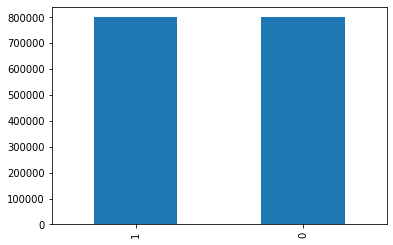

In [ ]:
# check dataset balance
data['sentiment'].value_counts().plot(kind='bar')

#### Supervised learning: Sentiment classifier using a Support Vector Machine (SVM)

In [ ]:
#since the dataset is very big, a subsample is taken using SKlearn for the SVM classifier
from sklearn.model_selection import train_test_split
x_ignore, x_use, y_ignore, y_use = train_test_split(data['cleancontent'], data['sentiment'], test_size=0.05, stratify=data['sentiment'])

#variables are reformatted for tensorflow
from sklearn.preprocessing import MultiLabelBinarizer
onehot_enc = MultiLabelBinarizer()
onehot_enc.fit(x_use)

#Sklearn is used to split data into train (50%) & test (50%)
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_use, y_use, test_size=0.2, stratify=y_use)

#convert to usable values
x_train_svm = x_train_svm.values
y_train_svm = y_train_svm.values
x_test_svm = x_test_svm.values
y_test_svm = y_test_svm.values

#apply lsvc
from sklearn.svm import LinearSVC
lsvm = LinearSVC(max_iter=10000)
lsvm.fit(onehot_enc.transform(x_train_svm), y_train_svm)

score = lsvm.score(onehot_enc.transform(x_test_svm), y_test_svm)
print('LSVM score: ', score)

LSVM score:  0.548375


In [ ]:
#output
lsvm_pred=lsvm.predict(onehot_enc.transform(df['cleancontent']))

df_lsvm=pd.DataFrame(data=lsvm_pred, columns=["pred_sentiment"])
df['lsvm_pred']=df_lsvm['pred_sentiment']
df[['content','lsvm_pred']]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['ó', 'ô', 'ö', 'ú', 'ğ', 'ı', 'ĺ', 'ō', 'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'ך', 'כ', 'ל', 'ם', 'מ', 'ן', 'נ', 'ס', 'ע', 'צ', 'ק', 'ר', 'ש', 'ת', '،', 'ء', 'آ', 'أ', 'ؤ', 'ا', 'ب', 'ة', 'ت', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ً', 'چ', 'ژ', 'ک', 'گ', 'ی', '۰', '۴', 'ँ', 'ं', 'अ', 'आ', 'इ', 'उ', 'ए', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ट', 'ठ', 'ड', 'त', 'थ', 'द', 'ध', 'न', 'प', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'े', 'ै', 'ो', '्', '।', 'ễ', '\u200b', '\u200c', '\u200e', '\u200f', '–', '—', '―', '‘', '’', '“', '”', '•', '…', '′', '€', '™', '●', '★', '☆', '☉', '☞', '♡', '➜', '《', 'ｒ', 'ｔ', '\U0010fc00'] will be ignored
  .format(sorted(unknown, key=str)))


,content,lsvm_pred
41905,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",0
41904,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,0
41903,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,0
41902,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",1
41901,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",0
...,...,...
4,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: http://tinyurl.com/qlux5e,1
3,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!,0
2,Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!,1
1,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!,0


Linear SVM leads to a relatively low test score. This might be due to tweets not being binary classifiable. A tweet could also be a fact or neutral.

#### Deep learning: Binary sentiment classifier using a Convolutional Neural Network

##### Download Google word embeddings
As explained by Vikram in guest lecture:

"Google trained its own word embeddings using News dataset (about 100 billion words) and produced 300-dimensional vectors for around 3 million words. The pre-trained 3 million word embeddings are available for public in [this website](https://code.google.com/archive/p/word2vec/)."

In [ ]:
#Download Google word embeddings
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" -O "GoogleNews-vectors-negative300.bin.gz"  # download Google's word embeddings
#!gunzip GoogleNews-vectors-negative300.bin.gz  # unzip downloaded word embeddings
!ls -lah  # list files in current directoty

--2020-05-17 12:41:37--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.92.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.92.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  95.3MB/s    in 16s     

2020-05-17 12:41:53 (95.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

total 1.6G
drwxr-xr-x 1 root root 4.0K May 17 12:35  .
drwxr-xr-x 1 root root 4.0K May 17 08:00  ..
drwxr-xr-x 1 root root 4.0K May 13 16:29  .config
drwx------ 4 root root 4.0K May 17 12:35  drive
-rw-r--r-- 1 root root 1.6G Mar  5  2015  GoogleNews-vectors-negative300.bin.gz
drwxr-xr-x 1 root root 4.0K May 13 16:29  sample_data
-rw-r--r-- 1 root root  14K May 17 08:32 'twump_ trending_topics.csv'


In [ ]:
#read word embeddings using the Gensim library
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
# check this https://radimrehurek.com/gensim/models/word2vec.html
# binary = true is because the word2vec file we have has a bin suffix, if it's text file, binary = false
# key is the word, value is a 300 dimensional vector for each word

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Since Keras only splits train/validation based on index location, it is preferable to use SciKit learn which can can randomize the split samples

In [ ]:
#Sklearn is used to split data into train (80%) & test (20%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data['content'], data['sentiment'], test_size=0.2, stratify=data['sentiment'])

#variables are reformatted for tensorflow
x_train = x_train.values
y_train = keras.utils.to_categorical(y_train.values)
x_test = x_test.values
y_test=keras.utils.to_categorical(y_test.values)

#print to check shape of variables, both sets should include positive and negative values
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1280000,) (1280000, 2)
(320000,) (320000, 2)


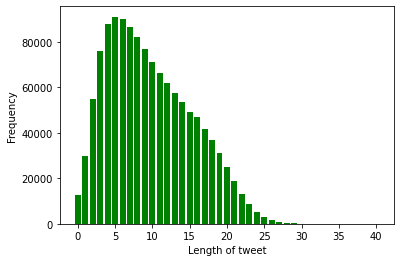

In [ ]:
# plot frequencies of sentences length
d = {}
for i,x in enumerate(x_train):
    n = sum([1 for w in x.split() if w in word2vec])
    if n in d: d[n] = d[n] + 1
    else: d[n] = 1
plt.bar(list(d.keys()), d.values(), color='g')
plt.xlabel('Length of tweet')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Tensorflow tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data['content'].values) 

# pad sequences max length=50 as longest sentence appears to be around 30
max_length = 50

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

# Transforms each text to a sequence of integers (to be used later in embeddings layer)
X_train_tokens =  tokenizer_obj.texts_to_sequences(x_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

# append zeros to make the text of the same length (use 'pad_sequences' function)
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length)

In [ ]:
#define embeding dimensions
EMBEDDING_DIM = 300

# create lookup table (matrix of Vocab x emb_dim)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer_obj.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)

##### Training the model
WARNING: This takes 8 hours! Skip steps when reading the notebook for review

Note: this model takes around 8 hours to train. For review purposes the training can be skipped by loading the pre-trained model.

In [ ]:
# build the neural network
model = keras.models.Sequential()
model.add(keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
          weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(0.0002), metrics=['accuracy'])

model.summary()

# training the model, 10 epochs
model.fit(x=X_train_pad, y=y_train, epochs=10, verbose=1, validation_data=(X_test_pad, y_test), shuffle=True, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           95528100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 32)            67232     
_________________________________________________________________
batch_normalization_3 (Batch (None, 44, 32)            128       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 42, 32)            3104      
_________________________________________________________________
batch_normalization_4 (Batch (None, 42, 32)            128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 32)           

In [ ]:
#save model
from tensorflow.keras.models import load_model

#replace with wherever you would like to save
model.save('/content/drive/My Drive/Trump Tweets/Tweet_sentiment_modelv1.h5')

In [ ]:
#Plot model accuracy and loss
def plot_accuracy_and_loss(model):
    epochs = model.history.params['epochs']
    epochs = range(epochs)
    val_loss = model.history.history['val_loss']
    val_accuracy = model.history.history['val_accuracy']
    training_loss = model.history.history['loss']
    training_accuracy = model.history.history['accuracy']

    plt.plot(epochs, val_loss, 'r', label='test')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='test')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model)

##### Running the model
Continue from here to skip the training and see the output of the pre-trained model

In [ ]:
#download model from https://github.com/WouterJTB/TWUMP/raw/master/Tweet_sentiment_modelv1.h5
#load model
from tensorflow import keras

#replace file loc with wherever you downloaded the file
file_loc='/content/drive/My Drive/Tutorials Courses/Trump Tweets/Tweet_sentiment_modelv1.h5'

model_loaded=keras.Sequential()
model_loaded.add(keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
          weights=[embedding_matrix], input_length=max_length, trainable=False))
model_loaded.add(keras.layers.Dropout(0.2))
model_loaded.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_loaded.add(keras.layers.BatchNormalization())
model_loaded.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_loaded.add(keras.layers.BatchNormalization())
model_loaded.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_loaded.add(keras.layers.BatchNormalization())
model_loaded.add(keras.layers.GlobalAveragePooling1D())
model_loaded.add(keras.layers.Dense(2, activation='softmax'))

model_loaded.load_weights(file_loc)

model_loaded.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(0.0002), metrics=['accuracy'])

##### Using trained model to classify Trump's tweets

In [ ]:
#If df not loaded: df=pd.DataFrame(data=pd.read_csv('/content/drive/My Drive/Trump Tweets/TrumpTweetsGOTscrape.csv')) andclean content as done earlier
df #print

,ts,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml,hour_of_day,day_of_the_week,datetime,day,month,year,time,dayofweek,weekend,partofday,cleancontent,lsvm_pred
41905,2020-03-11 22:04:26+00:00,1237861968721010689,2020-03-11,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",NaN,NaN,NaN,47393,237273,https://twitter.com/realDonaldTrump/status/1237861968721010689,NaN,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",22,2,2020-03-11 22:04:26+00:00,11,3,2020,22:04:26,2,0,night,the media should view this as a time of unity and strength we have a common enemy actually an enemy of the world the coronavirus we must beat it as quickly and safely as possible there is nothing more important to me than the life safety of the united states,0
41904,2020-03-11 20:44:36+00:00,1237841878889840642,2020-03-11,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,NaN,NaN,NaN,27031,127048,https://twitter.com/realDonaldTrump/status/1237841878889840642,NaN,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,20,2,2020-03-11 20:44:36+00:00,11,3,2020,20:44:36,2,0,night,i will be addressing the nation this evening at 900 pm eastern from the oval office,0
41903,2020-03-11 19:18:35+00:00,1237820230296010752,2020-03-11,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,NaN,NaN,NaN,27966,151657,https://twitter.com/realDonaldTrump/status/1237820230296010752,NaN,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,19,2,2020-03-11 19:18:35+00:00,11,3,2020,19:18:35,2,0,night,i am fully prepared to use the full power of the federal government to deal with our current challenge of the coronavirus,0
41902,2020-03-11 19:17:50+00:00,1237820042735226887,2020-03-11,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",NaN,NaN,NaN,13479,53168,https://twitter.com/realDonaldTrump/status/1237820042735226887,NaN,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,i want to thank all of our great government officials on the coronavirus task force who are working around the clock in response to the coronavirus continue to check for updates and follow all recommendations that are available,1
41901,2020-03-11 19:17:50+00:00,1237820044198977536,2020-03-11,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",NaN,NaN,NaN,9556,40112,https://twitter.com/realDonaldTrump/status/1237820044198977536,NaN,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,we have the greatest healthcare system experts scientists and doctors anywhere in the world together we will prevail,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2009-05-08 20:40:15+00:00,1741160716,2009-05-08,New Blog Post: Celebrity Appren

In [ ]:
# Tokenize input text
pred_source = df['cleancontent'].str.lower().astype(str).values
pred_tokens =  tokenizer_obj.texts_to_sequences(pred_source)

# Pad input text max_lenght value taken from earlier cell
pred_pad = pad_sequences(pred_tokens, maxlen=max_length)

In [ ]:
#Add prediction columns to dataset and save as csv

model_pred=model_loaded.predict(pred_pad)
dfp=pd.DataFrame(data=model_pred, columns=["p_negative_CNN1","p_positive_CNN1"])
df["p_negative_CNN1"]=dfp["p_negative_CNN1"]
df["p_positive_CNN1"]=dfp["p_positive_CNN1"]
df

,ts,id,date,content,response_to,mentions,hashtags,retweets,favorites,link,geo,content_nohtml,hour_of_day,day_of_the_week,datetime,day,month,year,time,dayofweek,weekend,partofday,cleancontent,lsvm_pred,p_negative_CNN1,p_positive_CNN1
41905,2020-03-11 22:04:26+00:00,1237861968721010689,2020-03-11,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",NaN,NaN,NaN,47393,237273,https://twitter.com/realDonaldTrump/status/1237861968721010689,NaN,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",22,2,2020-03-11 22:04:26+00:00,11,3,2020,22:04:26,2,0,night,the media should view this as a time of unity and strength we have a common enemy actually an enemy of the world the coronavirus we must beat it as quickly and safely as possible there is nothing more important to me than the life safety of the united states,0,0.069389,0.930611
41904,2020-03-11 20:44:36+00:00,1237841878889840642,2020-03-11,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,NaN,NaN,NaN,27031,127048,https://twitter.com/realDonaldTrump/status/1237841878889840642,NaN,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,20,2,2020-03-11 20:44:36+00:00,11,3,2020,20:44:36,2,0,night,i will be addressing the nation this evening at 900 pm eastern from the oval office,0,0.069389,0.930611
41903,2020-03-11 19:18:35+00:00,1237820230296010752,2020-03-11,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,NaN,NaN,NaN,27966,151657,https://twitter.com/realDonaldTrump/status/1237820230296010752,NaN,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,19,2,2020-03-11 19:18:35+00:00,11,3,2020,19:18:35,2,0,night,i am fully prepared to use the full power of the federal government to deal with our current challenge of the coronavirus,0,0.030554,0.969446
41902,2020-03-11 19:17:50+00:00,1237820042735226887,2020-03-11,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",NaN,NaN,NaN,13479,53168,https://twitter.com/realDonaldTrump/status/1237820042735226887,NaN,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,i want to thank all of our great government officials on the coronavirus task force who are working around the clock in response to the coronavirus continue to check for updates and follow all recommendations that are available,1,0.014069,0.985931
41901,2020-03-11 19:17:50+00:00,1237820044198977536,2020-03-11,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",NaN,NaN,NaN,9556,40112,https://twitter.com/realDonaldTrump/status/1237820044198977536,NaN,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",19,2,2020-03-11 19:17:50+00:00,11,3,2020,19:17:50,2,0,night,we have the greatest healthcare system experts scientists and doctors anywhere in the world together we will prevail,0,0.067341,0.932659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Looking at the output, some seem a bit curious. I.e. the tweet at index 41910 reads: "New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: *link*" which gets a 0.93 score on positive, although it seems to be more of a neutral statement. It might be that the model, being trained on positive/negative only, forces a positive/negative sentiment on tweets, not allowing for the tweets to be neutral. To verify, the same model is trained on a different dataset.

### Second Dataset: Three class classifiers
Including neutral sentiment

*   Dataset: *Niek Sanders' hand classified tweets*
*   URL: https://github.com/zfz/twitter_corpus


For this model, the Google word embeddings needs to be dowloaded and the embedding needs to be readusing the gensim library, as was done for the Binary Classifier 

In [ ]:
#load training data (Niek Sanders' hand classified Tweets)
train_test_source_Niek=pd.read_csv('https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv', header=0, sep=',')
train_test_source_Niek

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to the iPhone 4S (just announced)
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to @Apple iPhone. See ya!
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twitter was ios5 thanks @apple
...,...,...,...,...,...
5108,twitter,irrelevant,126855687060987904,Thu Oct 20 03:02:07 +0000 2011,me re copè con #twitter
5109,twitter,irrelevant,126855171702661120,Thu Oct 20 03:00:04 +0000 2011,Buenas noches genteeee :) #twitter los quierooo ...
5110,twitter,irrelevant,126854999442587648,Thu Oct 20 02:59:23 +0000 2011,#twitter tiene la mala costumbre de ponerce bno cuano yo me voy :/
5111,twitter,irrelevant,126854818101858304,Thu Oct 20 02:58:40 +0000 2011,"Oi @flaviasansi. Muito bem vinda ao meu #Twitter. Sempre dou followback pelo meu perfil profissional. Permaneça por aqui, certo? Abrass!"


As can be see above, the sentiment column also includes the label: 'irrelevant'. These will be ignored for train/test set.

In [ ]:
#drop irrelevant tweets
data_niek=train_test_source_Niek[train_test_source_Niek.Sentiment != 'irrelevant']
#label with integers
data_niek['Sentiment']=data_niek['Sentiment'].replace(['positive','neutral','negative'],[2,1,0])
data_niek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,2,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is
1,apple,2,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to the iPhone 4S (just announced)
2,apple,2,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY
3,apple,2,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to @Apple iPhone. See ya!
4,apple,2,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twitter was ios5 thanks @apple
...,...,...,...,...,...
4537,twitter,1,126855838047547392,Thu Oct 20 03:02:43 +0000 2011,"@madtruckman 'Modern Day Autograph"", I like the way you put that. #twitter"
4538,twitter,1,126855191571070976,Thu Oct 20 03:00:09 +0000 2011,62 Ways to Use #Twitter for Business: http://t.co/jYXK7OkC #tweets #socialmedia
4539,twitter,1,126854358817181696,Thu Oct 20 02:56:50 +0000 2011,"Log off #Facebook On #Twitter , But I Think i'm bout to going to sleep..."
4540,twitter,1,126853667738497025,Thu Oct 20 02:54:05 +0000 2011,"""#twitter's dumb, I don't like it."" Hush up, Justin."


1    2333
0     572
2     519
Name: Sentiment, dtype: int64

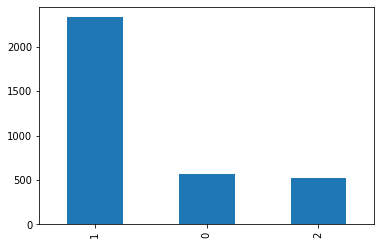

In [ ]:
# check if dataset is balanced (number of positive sentiment = number of negative sentiment)
data_niek['Sentiment'].value_counts().plot(kind='bar')
data_niek['Sentiment'].value_counts()

#### Rebalancing
Since the dataset is not balanced, labeled data is added from the sentiment140 dataset.

In [ ]:
balance_set[['content','Sentiment']]=data[['cleancontent','sentiment']]
balance_set['Sentiment']=balance_set['Sentiment'].replace([1],[2])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#split data into positive and negative values
balance_pos=balance_set[balance_set.Sentiment == 2]
balance_neg=balance_set[balance_set.Sentiment == 0]
print(balance_pos.head())
print(balance_neg.head())

                                                                                                                                     content  ... Sentiment
800000                                                                                              i love health4uandpets u guys r the best  ...         2
800001                                                                     im meeting up with one of my besties tonight cant wait  girl talk  ...         2
800002  darealsunisakim thanks for the twitter add sunisa i got to meet you once at a hin show here in the dc area and you were a sweetheart  ...         2
800003                                being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup  ...         2
800004                                                                                         lovesbrooklyn2 he has that effect on everyone  ...         2

[5 rows x 4 columns]
                                          

In [ ]:
#Determine required numberof samples per label to balance the dataset
n_tpos=data_niek['Sentiment'].loc[data_niek['Sentiment'] == 2].count()
n_tneut=data_niek['Sentiment'].loc[data_niek['Sentiment'] == 1].count()
n_tneg=data_niek['Sentiment'].loc[data_niek['Sentiment'] == 0].count()

#print the values to be sure
n_pos=n_tneut-n_tpos
n_neg=n_tneut-n_tneg
print(n_pos,n_neg)

1814 1761


In [ ]:
#balance the dataframe
data2=data_niek[['TweetText','Sentiment']].rename(columns={'TweetText':'content'})
data2=data2.append(balance_pos.sample(n=n_pos), ignore_index=True)
data2=data2.append(balance_neg.sample(n=n_neg), ignore_index=True)

#check if the dataframe is balanced
data2['Sentiment'].value_counts()

2    2333
1    2333
0    2333
Name: Sentiment, dtype: int64

In [ ]:
#Clean content of the rebalanced dataset
#again, use bs4 to clean html coding
warnings.filterwarnings("ignore", category=UserWarning, module='bs4', message='.*looks like a URL.*')
data2['content_nohtml']=[BeautifulSoup(text, 'lxml').get_text() for text in data2['content'].astype(str) ]

# then clear retweet identifiers in content, as well as URL's, then standardize the text
data2['cleancontent'] = data2['content_nohtml'].astype(str).apply(lambda x : ' '.join([w for w in x.split() if not w.startswith(('rt @', 'http', 'pic.'))]))

# Finally, make lowercase and remove punctuation
data2['cleancontent'] = data2['cleancontent'].str.lower()
data2['cleancontent'] = [str(x).translate(str.maketrans('', '', string.punctuation)) for x in data2['cleancontent']]

#check headers
data2[['cleancontent','Sentiment']]

,cleancontent,Sentiment
0,now all apple has to do is get swype on the iphone and it will be crack iphone that is,2
1,apple will be adding more carrier support to the iphone 4s just announced,2
2,hilarious youtube video guy does a duet with apple s siri pretty much sums up the love affair,2
3,rim you made it too easy for me to switch to apple iphone see ya,2
4,i just realized that the reason i got into twitter was ios5 thanks apple,2
...,...,...
6994,upupaepops the sun shining as i type but we have had rain none stop virtually since friday sendin arm bands ur way just incase xx,0
6995,im watching the notebook and i actually find it sad im not heartless after all,0
6996,now i only wish that apple would sync my adcdev accounts,0
6997,is at homeextra tired,0


#### Supervised learning: Support Vector Machine

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
onehot_enc = MultiLabelBinarizer()
onehot_enc.fit(data2['content'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [ ]:
from sklearn.model_selection import train_test_split # 0.8 0.2 train test split
x_train_svm2, x_test_svm2, y_train_svm2, y_test_svm2 = train_test_split(data2['content'], data2['Sentiment'], test_size=0.2, stratify=data2['Sentiment'])

In [ ]:
from sklearn.svm import LinearSVC
lsvm2 = LinearSVC(max_iter=10000)
lsvm2.fit(onehot_enc.transform(x_train_svm2), y_train_svm2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
score = lsvm2.score(onehot_enc.transform(x_test_svm2), y_test_svm2)
print('SVM2 score: ', score)

SVM2 score:  0.5964285714285714


In [ ]:
#output of second SVM
lsvm2_pred=lsvm2.predict(onehot_enc.transform(df['cleancontent']))

df_lsvm2=pd.DataFrame(data=lsvm2_pred, columns=["pred_sentiment"])
df_lsvm2['pred_sentiment']=df_lsvm2['pred_sentiment'].replace([0,1,2],['negative','neutral','positive'])
df['lsvm2_pred']=df_lsvm2['pred_sentiment']
df[['content','lsvm2_pred']]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['\x92', 'º', 'è', 'í', 'ô', 'ö', 'ø', 'ú', 'ĺ', 'ō', 'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'ך', 'כ', 'ל', 'ם', 'מ', 'ן', 'נ', 'ס', 'ע', 'צ', 'ק', 'ר', 'ש', 'ת', '،', 'ء', 'آ', 'أ', 'ؤ', 'ا', 'ب', 'ة', 'ت', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ً', 'چ', 'ژ', 'ک', 'گ', 'ی', '۰', '۴', 'ँ', 'ं', 'अ', 'आ', 'इ', 'उ', 'ए', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ट', 'ठ', 'ड', 'त', 'थ', 'द', 'ध', 'न', 'प', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'े', 'ै', 'ो', '्', '।', 'ễ', '\u200b', '\u200c', '\u200e', '\u200f', '―', '′', '™', '●', '★', '☆', '☉', '☞', '♡', '➜', '《', 'ｒ', 'ｔ', '\U0010fc00'] will be ignored
  .format(sorted(unknown, key=str)))


,content,lsvm2_pred
41905,"The Media should view this as a time of unity and strength. We have a common enemy, actually, an enemy of the World, the CoronaVirus. We must beat it as quickly and safely as possible. There is nothing more important to me than the life & safety of the United States!",negative
41904,I will be addressing the Nation this evening at 9:00 P.M. (Eastern) from the Oval Office.,negative
41903,I am fully prepared to use the full power of the Federal Government to deal with our current challenge of the CoronaVirus!,negative
41902,"I want to thank all of our Great Government officials on the CoronaVirus Task Force who are working around the clock, in response to the CoronaVirus. Continue to check http://CDC.gov for updates, and follow all recommendations that are available....",positive
41901,"....We have the greatest healthcare system, experts, scientists and doctors anywhere in the world. Together, we will PREVAIL!",negative
...,...,...
4,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: http://tinyurl.com/qlux5e,positive
3,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!,negative
2,Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!,positive
1,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!,negative


#### Deep learning: Categorical classification using a convolutional neural network

In [ ]:
#Data is shuffled and then resampled into train-test samples
from sklearn.model_selection import train_test_split # 0.8 0.2 train test split
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(data2['content'], data2['Sentiment'], test_size=0.2, shuffle=True,stratify=data2['Sentiment'])

#Then one-hot-encoded
x_train_cnn = x_train_cnn.values
y_train_cnn = keras.utils.to_categorical(y_train_cnn.values)
x_test_cnn = x_test_cnn.values
y_test_cnn=keras.utils.to_categorical(y_test_cnn.values)


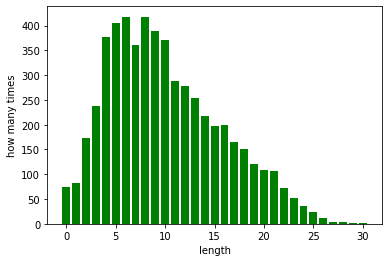

In [ ]:
# plot frequencies of sentences length
import matplotlib.pyplot as plt
d = {}
for i,x in enumerate(x_train_cnn):
    n = sum([1 for w in x.split() if w in word2vec])
    if n in d: d[n] = d[n] + 1
    else: d[n] = 1
plt.bar(list(d.keys()), d.values(), color='g')
plt.xlabel('length')
plt.ylabel('how many times')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data2['content'].values) 

# pad sequences, max length is set a bit stricter this time
max_length_cnn = 35

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

# Transforms each text to a sequence of integers (to be used later in embeddings layer)
X_train_tokens_cnn =  tokenizer_obj.texts_to_sequences(x_train_cnn)
X_test_tokens_cnn = tokenizer_obj.texts_to_sequences(x_test_cnn)

# append zeros to make the text of the same length (use 'pad_sequences' function)
X_train_pad_cnn = pad_sequences(X_train_tokens_cnn, maxlen=max_length_cnn)
X_test_pad_cnn = pad_sequences(X_test_tokens_cnn, maxlen=max_length_cnn)

In [ ]:
EMBEDDING_DIM = 300

# create lookup table (matrix of Vocab x emb_dim)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer_obj.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)

In [ ]:
# build the neural network
model_cnn = keras.models.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
          weights=[embedding_matrix], input_length=max_length_cnn, trainable=False))
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.GlobalAveragePooling1D())
model_cnn.add(keras.layers.Dense(3, activation='softmax'))

#The model is similar to the first CNN, except this labels in 3 categories. 
#Therefore the output layer has 3 nodes and the loss function is set to categorical crossentropy
model_cnn.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(0.0001), metrics=['accuracy'])

model_cnn.summary()

# train the model on the training data for 10 epochs with X_test_pad & y_test as validation data
model_cnn.fit(x=X_train_pad_cnn, y=y_train_cnn, epochs=50, verbose=1, validation_data=(X_test_pad_cnn, y_test_cnn), shuffle=True, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 35, 300)           4675800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 300)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 29, 32)            67232     
_________________________________________________________________
batch_normalization_12 (Batc (None, 29, 32)            128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 27, 32)            3104      
_________________________________________________________________
batch_normalization_13 (Batc (None, 27, 32)            128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 25, 32)           

In [ ]:
#save model
from tensorflow.keras.models import load_model

#replace with wherever you would like to save
model_cnn.save('/content/drive/My Drive/Tutorials Courses/Trump Tweets/Tweet_sentiment_inc_neutral.h5')

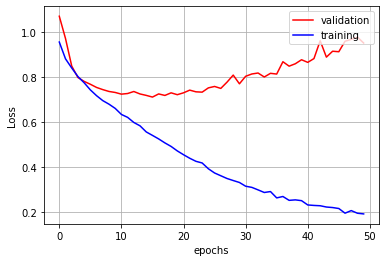

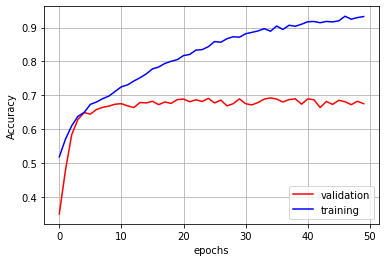

In [ ]:
def plot_accuracy_and_loss(model_cnn):
    epochs = model_cnn.history.params['epochs']
    epochs = range(epochs)
    val_loss = model_cnn.history.history['val_loss']
    val_accuracy = model_cnn.history.history['val_accuracy']
    training_loss = model_cnn.history.history['loss']
    training_accuracy = model_cnn.history.history['accuracy']

    plt.plot(epochs, val_loss, 'r', label='validation')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='validation')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model_cnn)

#### Model results

In [ ]:
#Apply model
# Transforms each text to a sequence of integers (to be used later in embeddings layer)
pred_source = df['cleancontent'].values
pred_tokens =  tokenizer_obj.texts_to_sequences(pred_source)

# append zeros to make the text of the same length (use 'pad_sequences' function)
pred_pad = pad_sequences(pred_tokens, maxlen=max_length_cnn)

In [ ]:
#predict on trump's tweets
model_pred=model_cnn.predict(pred_pad)
dfp=pd.DataFrame(data=model_pred, columns=["p_1","p_2","p_3"])

#add to dataframe
df["p_CNN_negative"]=dfp["p_1"]
df["p_CNN_neutral"]=dfp["p_2"]
df["p_CNN_positive"]=dfp["p_3"]

#check of the high confidence predictions make sense
dfpos=df[df.p_CNN_positive > 0.99]
dfneu=df[df.p_CNN_neutral > 0.95]
dfneg=df[df.p_CNN_negative > 0.99]

print(dfpos[['cleancontent','p_CNN_positive']].head())
print(dfneu[['cleancontent','p_CNN_neutral']].head())
print(dfneg[['cleancontent','p_CNN_negative']].head())

                                                                                                                                                                                                                                                                      cleancontent  p_CNN_positive
41879                                                                                                                         there is another russia russia russia meeting today it is headed up by corrupt politician adam “shifty” schiff so i wouldn’t expect too much dhswolf        0.996094
41878                                                                                                                                                                                              the federal reserve must be a leader not a very late follower which it has been        0.991549
41872                       wow foxandfriends blew away the competition of morning joke which did very poorly on msdnc another 

In [ ]:
df.to_csv('/content/drive/My Drive/Tutorials Courses/Trump Tweets/TrumpTweets_fully_classified.csv')

# 4 Reflection

**Problems encountered with the twitter scraper**
- The Twitter API kicks out the scraper after it exceeds a threshold of x tweets per time, which will block a new connection for 1hr. What amount of tweets in what amount of time this threshold is is unclear (apparently it has to do with Twitter's server load). In the last version we have set the scraper to scrape 1500 tweets per loop with intervals of 2 minutes between each loop.
- GetOldTweets3 reads tweets in order from most recent to least recent, therefore the scraper had to be set to scrape tweets from the most recent time to least recent time. This means that new tweets that are posted after the scraper is already running will not be added to the dataset automatically. Instead the scraper would have to be started again to add the new data to the dataset.

**Problems encountered during model application** 
- The first model had some unexpected results, where tweets that we would consider to be neutral are forced to be classified as either positive/negative by the model that was trained on positive/negative only.


**Task description**

There were several ideas regarding the goal of this project throughout the process. The ideas ranged from building a simple trump tweet generator which responded to news publications, to predicting Trump’s tweets based on the topic of the day. However, we were not able to obtain a usable dataset that would provide enough input to train a model in such a way. Our twitter scraping library did not have the functionality to scrape trending twitter topics on a given day, and even if we would use topics from another source, such as google trends, we ran into the issue of the complexity of the model. For example, a convolutional neural network could have reasonable performance as a classifier, but not so much for generating proper sentences. Whereas a standard recurrent neural network posed the problem of where in a sentence the topics would be placed and how the model would determine what topic to pick and where to place it. We eventually simplified our problem to be a more general classification problem and trained two twitter sentiment classifier based on two datasets. Since the first dataset was labeled by a support vector machine, there was a risk that the labels in the dataset were not correctly assigned, due to accuracy limitations of the model. Since the second dataset consisted of hand classified tweets, the model trained on cleaner data which generated better results.

**Course review**

Overall the course was very nice to start getting a feeling of training neural networks in tensorflow. Especially the guest lectures of Vikram provided a very good background in the intuition of the models and how information is generally interpreted as data. In general it might have been nice to have a bit more focus on the fundamentals (such as the mathematics, the commonly used models and the intuition behind them, what to consider when adding layers/nodes) and a bit less on the implementation during the lectures. So that the actual implementation would be figured out when working on the assignment itself. In the end we found that we based most of our actual coding on what we could find online, since the coding was pretty topic specific. However overall our experience with the course was very positive and it was a nice first introduction to deep learning. 
